In [1]:
# import libraries
import json
import re
from textblob import TextBlob
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to plot graph and regression line from given dataframe
def plot_graph_and_regression_line(df):
    # Create copy
    df_copy = df.copy()

    # Create a new column for number of months from starting month
    df_copy["Month from start"] = (df_copy["Month-Year"] - df_copy["Month-Year"][0]).astype(np.float32)

    # x and y values for model
    x = df_copy["Month from start"].values.reshape(-1, 1)
    y = df_copy["count"].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(x, y)
    #r_sq = model.score(months_from_start, number_of_reactions)

    # Predicted likes_and_reactions values
    y_pred = model.predict(x)
    #rmse = (np.sqrt(np.mean(np.array(y - y_pred) ** 2)))

    # Plot graph and regression line
    f, ax = plt.subplots()
    df.plot.line("Month-Year", "count", ax = ax)
    ax.plot(df["Month-Year"], y_pred, color = "red")
    
    # Set labels and legend
    plt.xlabel("Month-Year")
    plt.ylabel("Count")
    plt.legend(["Actual", "Slope = " + str(round(float(model.coef_), 2))], loc ="upper right")

## Group Membership Activity

In [3]:
# Import dataset and load file
with open("groups/your_group_membership_activity.json") as json_file:
    group_membership_data = json.load(json_file) 
    
# Get titles and timestamps associated with all groups
group_membership_timestamp = []
group_membership_title = []

for group in group_membership_data["groups_joined"]:
    group_membership_timestamp.append(group["timestamp"])
    group_membership_title.append(group["title"])

# Get group names and action - became a member or stopped being a member
group_titles = group_membership_title.copy()
group_names = []
group_action = []
group_sentiment_score = []

for i in range(len(group_titles)):
    group_action.append(re.split(" ", group_titles[i])[1])  # split title into words then pick 2nd word
    group_names.append(" ".join(re.split("of ", group_titles[i])[1:])[:-1])  # split title by "of " and return everything after first "of "
    group_sentiment_score.append(TextBlob(group_names[i]).sentiment.polarity) # get sentiment score of group name

# Create dataframe
groups = pd.DataFrame({"Group Name": group_names, 
                       "Action": group_action, 
                       "Date": group_membership_timestamp, 
                       "Sentiment Score": group_sentiment_score})

# Convert timestamps to datetime objects 
groups["Date"] = pd.to_datetime(groups["Date"], unit='s')

#### Positive, Negative and Neutral Groups

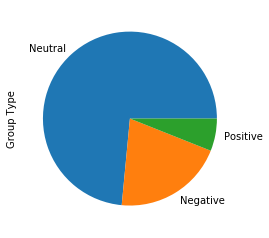

In [4]:
# Consider only the groups that you became a member of
member_groups = groups[groups["Action"] == "became"]

# Include only group names and their sentiment scores 
member_groups = member_groups[["Group Name", "Sentiment Score"]]

# Include new column stating whether group is positive, negative or neutral
group_type = []
for score in member_groups["Sentiment Score"]:
    if score > 0:
        group_type.append("Positive")
    elif score < 0:
        group_type.append("Negative")
    else:
        group_type.append("Neutral")

member_groups["Group Type"] = group_type

# Plot a pie chart
member_groups['Group Type'].value_counts().plot(kind='pie')

## Activity in groups

#### (1) Likes and Reactions in groups

<built-in method date of Timestamp object at 0x0000011F72EC3D48>


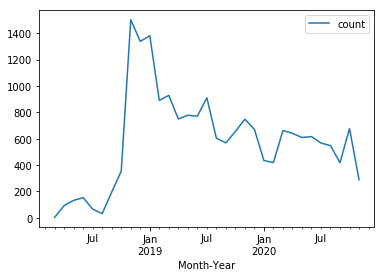

In [5]:
# Import dataset and load file
with open("likes_and_reactions/posts_and_comments.json") as json_file:
    likes_and_reactions_data = json.load(json_file)
    
# Get all likes and reactions in all groups and their timestamps
reaction_group = []
reaction_timestamp = []
reaction_reaction = []

regex = r"\w+ in (?P<groupname>[\w -_\\ ]+.$)" # get group name (occurs after "in")
for reaction in likes_and_reactions_data["reactions"]:
    if re.search(regex, reaction["title"]): # check if the reaction is in a group 
        m = re.search(regex, reaction["title"]) # search for group name in "title"
        name = m.group("groupname")
        reaction_group.append(name)
        reaction_timestamp.append(reaction["timestamp"])
        
        for r in reaction["data"]:
            reaction_reaction.append(r["reaction"]["reaction"])

# Create dataframe            
likes_and_reactions_df = pd.DataFrame({"Group Name": reaction_group, 
                                       "Date": reaction_timestamp, 
                                       "Reaction Type": reaction_reaction})

# Convert timestamps to datetime objects
likes_and_reactions_df["Date"] = pd.to_datetime(likes_and_reactions_df["Date"], unit='s')
print(likes_and_reactions_df["Date"][0].date)

# Create column containing only month and year from datetime
likes_and_reactions_df['Month-Year'] = pd.to_datetime(likes_and_reactions_df["Date"]).dt.to_period('M')

# Include only group name, reaction and month-year columns (drop Date)
likes_and_reactions_df = likes_and_reactions_df[["Group Name", "Reaction Type", "Month-Year"]]

# Get count of reactions in each Month-Year
likes_and_reactions_df = likes_and_reactions_df.groupby(likes_and_reactions_df["Month-Year"])["Reaction Type"].agg(["count"])
# Convert Month-Year (index) to column  
likes_and_reactions_df["Month-Year"] = likes_and_reactions_df.index
# Start index from "0"
likes_and_reactions_df.index = range(len(likes_and_reactions_df))
# Create new column containing the activity type i.e. likes/reaction
likes_and_reactions_df["Activity Type"] = ["Likes/Reaction"] * len(likes_and_reactions_df)

# Plot a line graph showing number of likes/reactions over time
lines = likes_and_reactions_df.plot.line("Month-Year", "count")

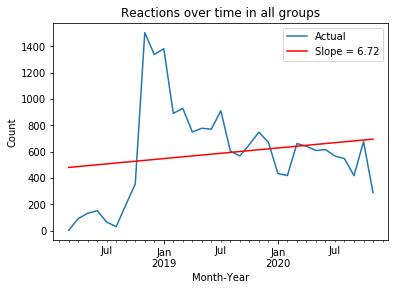

In [6]:
# Plot the graph and regression line for number of likes/reactions over time
plot_graph_and_regression_line(likes_and_reactions_df)

# Set Title
plt.title("Reactions over time in all groups")

# Save plot
plt.savefig("reactions.png", bbox_inches='tight')
plt.show()

#### (2) Comments and Posts in groups

In [7]:
# Import dataset and load file
with open("groups/your_posts_and_comments_in_groups.json") as json_file:
    posts_comments_data = json.load(json_file) 

##### Comments in groups

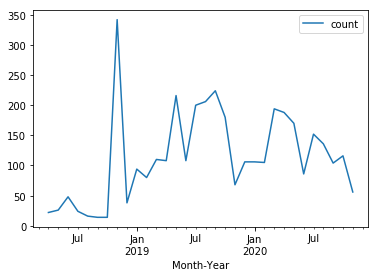

In [8]:
# Get all comments in all groups and their timestamps
comment_group = []
comment_timestamp = []
comment_comment = []

for comment in posts_comments_data["group_posts"]["activity_log_data"]:
    try: #check if it's a comment
        comment_group.append(comment["data"][0]["comment"]["group"])
        comment_comment.append(comment["data"][0]["comment"]["comment"])
        comment_timestamp.append(comment["timestamp"])
    except: #if not a comment, do nothing
        pass
    
# Create dataframe            
comments_df = pd.DataFrame({"Group Name": comment_group, 
                            "Date": comment_timestamp, 
                            "Comment": comment_comment})

# Convert timestamps to datetime objects
comments_df["Date"] = pd.to_datetime(comments_df["Date"], unit='s')

# Create column containing only month and year from datetime
comments_df['Month-Year'] = pd.to_datetime(comments_df["Date"]).dt.to_period('M')

# Include only group name, comment and month-year columns (drop Date)
comments_df = comments_df[["Group Name", "Comment", "Month-Year"]]

# Get count of comments in each Month-Year
comments_df_aggregate = comments_df.groupby(comments_df["Month-Year"])["Comment"].agg(["count"])
# Convert Month-Year (index) to column  
comments_df_aggregate["Month-Year"] = comments_df_aggregate.index
# Start index from "0"
comments_df_aggregate.index = range(len(comments_df_aggregate))
# Create new column containing the activity type i.e. Comment
comments_df_aggregate["Activity Type"] = ["Comment"] * len(comments_df_aggregate)

# Plot a line graph showing number of likes/reactions over time
lines = comments_df_aggregate.plot.line("Month-Year", "count")

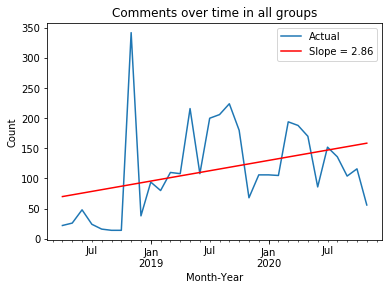

In [9]:
# Plot the graph and regression line for number of comments over time
plot_graph_and_regression_line(comments_df_aggregate)

# Set title
plt.title("Comments over time in all groups")

# Save plot 
plt.savefig("comments.png", bbox_inches='tight')
plt.show()

##### Posts in groups

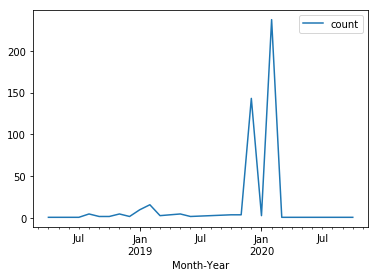

In [10]:
# Get all posts in all groups and their timestamps
post_group = []
post_timestamp = []
post_title = []
count = 0

for post in posts_comments_data["group_posts"]["activity_log_data"]:
    if " in " in post["title"]:
        post_group.append(''.join(re.split(" in ", post["title"])[1:])[:-1])  #split up group by " in " and returns everything after first " in "
        post_timestamp.append(post["timestamp"])
        post_title.append(post["title"])
        
# Create dataframe            
posts_df = pd.DataFrame({"Group Name": post_group, 
                         "Date": post_timestamp,
                         "Title": post_title})

# Convert timestamps to datetime objects
posts_df["Date"] = pd.to_datetime(posts_df["Date"], unit='s')

# Create column containing only month and year from datetime
posts_df['Month-Year'] = pd.to_datetime(posts_df["Date"]).dt.to_period('M')

# Include only group name, title and month-year columns (drop Date)
posts_df = posts_df[["Group Name", "Title", "Month-Year"]]

# Get count of comments in each Month-Year
posts_df = posts_df.groupby(posts_df["Month-Year"])["Title"].agg(["count"])
# Convert Month-Year (index) to column  
posts_df["Month-Year"] = posts_df.index
# Start index from "0"
posts_df.index = range(len(posts_df))
# Create new column containing the activity type i.e. Comment
posts_df["Activity Type"] = ["Post"] * len(posts_df)

# Plot a line graph showing number of likes/reactions over time
lines = posts_df.plot.line("Month-Year", "count")

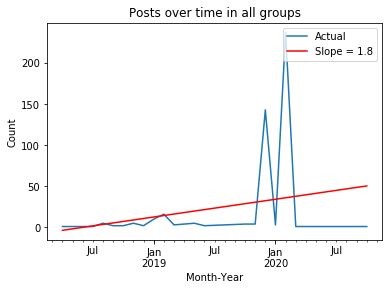

In [11]:
# Plot the graph and regression line for number of posts over time
plot_graph_and_regression_line(posts_df)

# Set title
plt.title("Posts over time in all groups")

# Save plot 
plt.savefig("posts.png", bbox_inches='tight')
plt.show()

### All activities in groups

#### Without Threshold

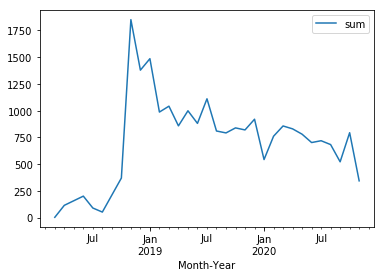

In [12]:
activities_in_groups_df = pd.concat([likes_and_reactions_df, comments_df_aggregate, posts_df], ignore_index=True)

# Get activity count (reactions, comments, posts) in each Month-Year
activities_in_groups_df = activities_in_groups_df.groupby(activities_in_groups_df["Month-Year"])["count"].agg(["sum"])
# Convert Month-Year (index) to column  
activities_in_groups_df["Month-Year"] = activities_in_groups_df.index
# Start index from "0"
activities_in_groups_df.index = range(len(activities_in_groups_df))

# Plot a line graph showing the activity over time
lines = activities_in_groups_df.plot.line("Month-Year", "sum")

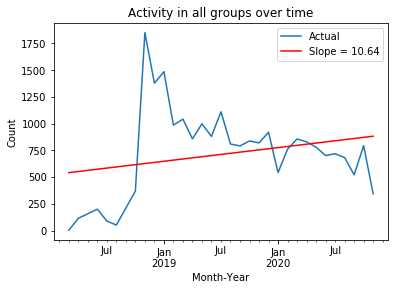

In [13]:
# Rename "sum" column to "count"
activities_in_groups_df = activities_in_groups_df.rename(columns={"sum" : "count"})

# Plot the graph and regression line for activity over time
plot_graph_and_regression_line(activities_in_groups_df)

# Set title
plt.title("Activity in all groups over time")

# Save plot
plt.savefig("activity_without_threshold.png", bbox_inches='tight')
plt.show()

#### With Threshold

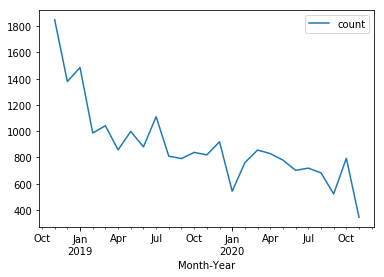

In [14]:
# Set threshold percentage
threshold_percent = 0.25
# Get threshold value
threshold = max(list(activities_in_groups_df["count"])) * threshold_percent

# Find first date where count is greater than threshold
for i in range(len(activities_in_groups_df)):
    if activities_in_groups_df["count"][i] > threshold:
        first_index = i
        first_date = activities_in_groups_df.index[i]
        break

# Create dataframe containing activities where count is greater than threshold
activities_in_groups_with_threshold_df = activities_in_groups_df.iloc[first_index:]
activities_in_groups_with_threshold_df.reset_index(drop = True, inplace = True)

# Plot a line graph showing the activity over time
activities_in_groups_with_threshold_df.plot.line("Month-Year", "count")

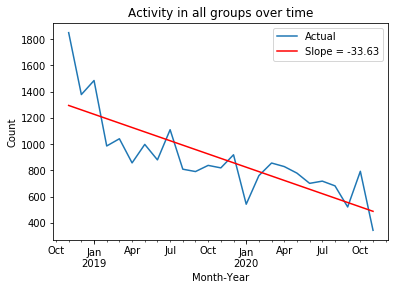

In [15]:
# Plot the graph and regression line for activity with threshold over time
plot_graph_and_regression_line(activities_in_groups_with_threshold_df)

# Set title
plt.title("Activity in all groups over time")

# Save plot
plt.savefig("activity_with_threshold.png", bbox_inches='tight')
plt.show()

## Number of Friends tagged over time

In [16]:
# Create friends list
with open("friends/friends.json") as json_file:
    friends_df = json.load(json_file) 

friends_list = []
for i in friends_df["friends"]:
    friends_list.append(i["name"])

In [17]:
# Go through all comments and find which comments are tags
comment_tag_index = []
for i in range(len(comments_df["Comment"])):
    if any(friend in comments_df["Comment"][i] for friend in friends_list):
        comment_tag_index.append(i)

# Create comment tag dataframe
comment_tag_df = comments_df.iloc[comment_tag_index]
# Get tag count in each Month-Year
comment_tag_df = comment_tag_df.groupby(comment_tag_df["Month-Year"])["Comment"].agg(["count"])
# Convert Month-Year (index) to column
comment_tag_df['Month-Year'] = comment_tag_df.index
# Start index from "0"
comment_tag_df.index = range(len(comment_tag_df))

#### Without Threshold

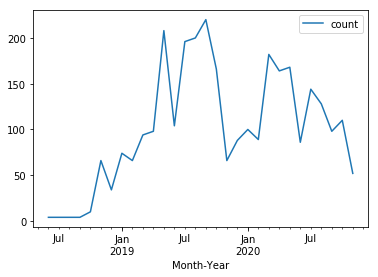

In [18]:
#plotting
comment_tag_df.plot.line("Month-Year", "count")

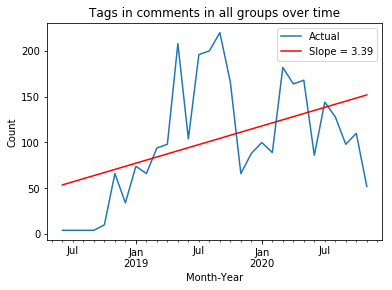

In [19]:
# Plot the graph and regression line for friends tagged over time
plot_graph_and_regression_line(comment_tag_df)

# Set title
plt.title("Tags in comments in all groups over time")

# Save plot
plt.savefig("tagging_without_threshold.png", bbox_inches='tight')
plt.show()

#### With Threshold

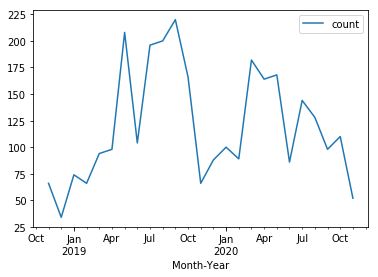

In [20]:
# Set threshold percentage
threshold_percent = 0.25
# Get threshold value
threshold_tag = max(comment_tag_df["count"]) * threshold_percent

# Find first date where count is greater than threshold
for i in range(len(comment_tag_df)):
    if comment_tag_df["count"][i] > threshold_tag:
        first_index = i
        first_date = comment_tag_df.index[i]
        break

# Create dataframe containing activities where count is greater than threshold
comment_tag_with_threshold_df = comment_tag_df.iloc[first_index:]
comment_tag_with_threshold_df.reset_index(drop = True, inplace = True)

# Plot a line graph showing the activity over time
comment_tag_with_threshold_df.plot.line("Month-Year", "count")

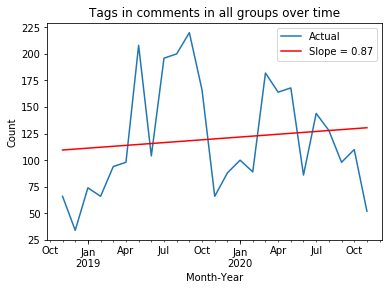

In [21]:
# Plot the graph and regression line for friends tagged (with threshold) over time
plot_graph_and_regression_line(comment_tag_with_threshold_df)

# Set title
plt.title("Tags in comments in all groups over time")

# Save plot
plt.savefig("tagging_with_threshold.png", bbox_inches='tight')
plt.show()